# Credit Scoring Model - Random Forest & XGBoost

In this notebook, we build and evaluate a credit scoring model to predict the probability of default on loans.  
The goal is to replicate the kind of risk assessment banks use: rank customers by risk and provide interpretable probabilities of default.

We will compare Random Forest and XGBoost, tune hyperparameters, calibrate probabilities, and evaluate the model using metrics widely used in credit risk modeling.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer
import xgboost as xgb

## Data Preparation

In [2]:
#Importing the cleaned dataset
df = pd.read_csv('../data/loans_feature_engineered.csv')
df.head()

,loan_amnt,term_months,int_rate,grade,sub_grade,emp_length_years_txt,home_ownership,annual_inc,dti,revol_util,earliest_cr_line,open_acc,default_status,high_grade,loan_to_income,critical_int_rate,int_rate_diff_from_grade,int_rate_ratio_grade,int_rate_bin
0,3600.0,36,0.140,C,C4,10,MORTGAGE,55000.0,0.059,0.297,22,7,0,0,0.065455,1,-0.001507,0.989353,6
1,24700.0,36,0.120,C,C1,10,MORTGAGE,65000.0,0.161,0.192,25,22,0,0,0.380000,0,-0.021507,0.848017,5
2,20000.0,60,0.108,B,B4,10,MORTGAGE,63000.0,0.108,0.562,25,6,0,0,0.317460,0,0.001188,1.011121,4
3,35000.0,60,0.149,C,C5,10,MORTGAGE,110000.0,0.171,0.116,16,13,0,0,0.318182,1,0.007493,1.052954,7
4,10400.0,60,0.225,F,F1,3,MORTGAGE,104433.0,0.254,0.645,27,12,0,1,0.099585,1,-0.029621,0.883667,13


In [3]:
#Creating a new data frame with only 50000 rows to speed up the process.
df_small, _ = train_test_split(df, train_size=50000, random_state=42, stratify=df['default_status'])
df_small.head()

,loan_amnt,term_months,int_rate,grade,sub_grade,emp_length_years_txt,home_ownership,annual_inc,dti,revol_util,earliest_cr_line,open_acc,default_status,high_grade,loan_to_income,critical_int_rate,int_rate_diff_from_grade,int_rate_ratio_grade,int_rate_bin
1292681,8000.0,36,0.142,C,C2,3,RENT,34560.0,0.189,0.591,22,11,0,0,0.231481,1,0.000493,1.003487,6
1453387,37200.0,60,0.105,B,B2,10,MORTGAGE,62300.0,0.169,0.222,22,15,0,0,0.597111,0,-0.001812,0.983034,4
677444,4800.0,36,0.074,A,A4,2,MORTGAGE,40000.0,0.305,0.039,23,25,1,0,0.120000,0,0.003124,1.044071,1
1523757,10000.0,60,0.185,D,D2,Unknown,MORTGAGE,26988.0,0.213,0.233,18,11,0,0,0.370535,1,0.003430,1.018889,10
314045,10850.0,60,0.217,E,E5,Unknown,RENT,32000.0,0.258,0.816,60,9,1,1,0.339062,1,-0.001380,0.993680,12


In [4]:
X = df_small.drop(columns=['default_status'])
y = df_small['default_status'].astype(int)

# Apply One-Hot Encoding to categorical features
cat_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 2. Train/test split (adjust with dates if a temporal variable is available)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Baseline Models

We started with two baseline algorithms:
- **Random Forest**: simple, robust, non-linear.
- **XGBoost**: gradient boosting, often competitive in tabular problems.

Baseline results showed similar performance for both models:
- Random Forest ROC-AUC ~0.70, PR-AUC ~0.258
- XGBoost ROC-AUC ~0.70, PR-AUC ~0.257

This indicates that the predictive ceiling is driven more by the dataset than the algorithm itself.


In [5]:
#Creating the base line model with Random Forest

# 3. Train Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=None,        # no limit on depth
    min_samples_leaf=50,   # prevents overfitting; adjust based on dataset size
    n_jobs=-1,             # use all available cores
    random_state=42
)
rf.fit(X_train, y_train)

# 4. Probability predictions
p = rf.predict_proba(X_test)[:, 1]

# 5. Evaluation metrics
print("ROC-AUC:", roc_auc_score(y_test, p))
print("PR-AUC:", average_precision_score(y_test, p))

ROC-AUC: 0.7010340693675137
PR-AUC: 0.25839673168950283


In [ ]:
# XGBoost model
params = {
    "n_estimators": 300,      # number of trees
    "learning_rate": 0.1,     # learning rate (shrinkage)
    "max_depth": 4,           # maximum depth of each tree
    "subsample": 0.8,         # fraction of rows sampled per tree
    "colsample_bytree": 0.8,  # fraction of features sampled per tree
    "scale_pos_weight": (y_train.value_counts()[0] / y_train.value_counts()[1])  # class weight balance
}

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",  # internal evaluation metric
    random_state=42,
    n_jobs=-1,
    **params
)

# Training
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC:", average_precision_score(y_test, y_pred_proba))


ROC-AUC: 0.7072059694404724
PR-AUC: 0.2572175291111419


## Hyperparameter Tuning

We used `RandomizedSearchCV` optimizing **PR-AUC** (more appropriate than ROC-AUC due to class imbalance).

Best Random Forest parameters:
- n_estimators = 500
- min_samples_split = 10
- min_samples_leaf = 25
- max_features = "sqrt"
- max_depth = None
- class_weight = "balanced"

With these settings, the tuned Random Forest achieved:
- ROC-AUC ≈ 0.704
- PR-AUC ≈ 0.262


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# Define base model
rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

# Hyperparameter search space
param_dist = {
    "n_estimators": [200, 500, 800, 1200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [5, 10, 25, 50],
    "max_features": ["sqrt", "log2"],
    "class_weight": [None, "balanced"]
}

# RandomizedSearchCV optimizing PR-AUC
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                  # test 20 random combinations
    scoring="average_precision",# <-- PR-AUC
    cv=5,                       # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Train randomized search
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

# Evaluate on test set
p = best_rf.predict_proba(X_test)[:, 1]
print("ROC-AUC (test):", roc_auc_score(y_test, p))
print("PR-AUC (test):", average_precision_score(y_test, p))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 25, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}
ROC-AUC (test): 0.7045466395123497
PR-AUC (test): 0.2600600158935128


In the previous search we also optimized the `class_weight` parameter.  
However, since the dataset is imbalanced and the use of `"balanced"` proved to be more effective,  
we now **fix `class_weight="balanced"`** and focus the hyperparameter search on the other parameters.  

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# Define base model
rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

# Hyperparameter search space
param_dist = {
    "n_estimators": [200, 500, 800, 1200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [5, 10, 25, 50],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced"]
}

# RandomizedSearchCV optimizing PR-AUC
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                  # test 20 random combinations
    scoring="average_precision",# <-- PR-AUC
    cv=5,                       # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Train search
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

# Evaluate on test set
p = best_rf.predict_proba(X_test)[:, 1]
print("ROC-AUC (test):", roc_auc_score(y_test, p))
print("PR-AUC (test):", average_precision_score(y_test, p))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 25, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
ROC-AUC (test): 0.7039666862890779
PR-AUC (test): 0.261594257334008


In [7]:
#Trying with the best model

rf_final = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=25,
    max_features='sqrt',
    min_samples_leaf=25,
    class_weight='balanced',
    random_state=42
)

rf_final.fit(X_train, y_train)
p = rf_final.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, p))
print("PR-AUC:", average_precision_score(y_test, p))

ROC-AUC: 0.7039666862890779
PR-AUC: 0.261594257334008


## Robust Validation

We applied 5-fold stratified cross-validation to test stability.

Results:
- ROC-AUC: 0.717 ± 0.007
- PR-AUC: 0.277 ± 0.011

This shows the model is stable and not dependent on a lucky split.


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_scores = cross_val_score(best_rf, X, y, cv=cv, scoring="roc_auc")
pr_scores  = cross_val_score(best_rf, X, y, cv=cv, scoring="average_precision")

print("ROC-AUC:", roc_scores.mean(), "+/-", roc_scores.std())
print("PR-AUC:", pr_scores.mean(), "+/-", pr_scores.std())

ROC-AUC: 0.7166126288675437 +/- 0.0073209411660966625
PR-AUC: 0.27651705977344215 +/- 0.011121204202044137


## Feature Importance

Permutation importance and SHAP values indicate the most predictive variables:
- Interest rate
- Interest rate bin
- High grade
- Interest rate by grade

These features are aligned with domain knowledge: higher interest rates and higher DTI correlate with higher risk of default.


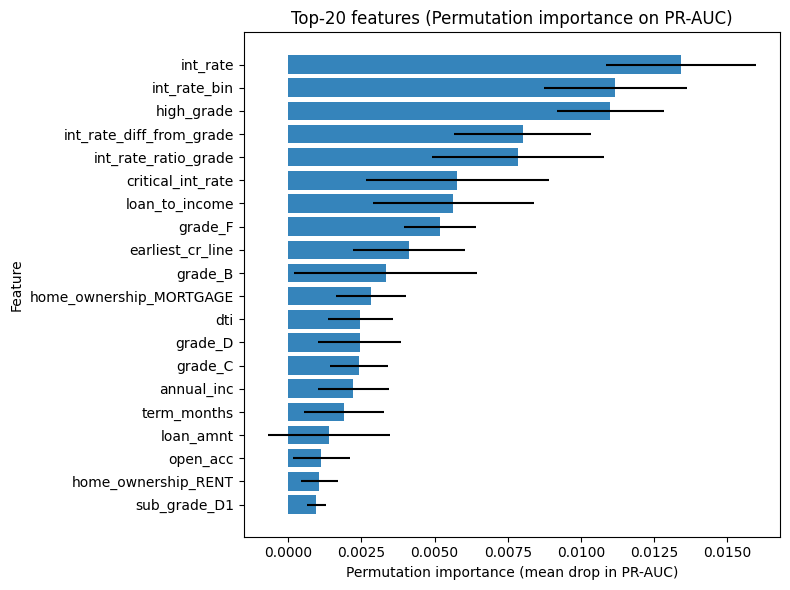

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_final, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1,
    scoring="average_precision"
)

imp_perm = pd.Series(result.importances_mean, index=X_test.columns)
imp_std  = pd.Series(result.importances_std, index=X_test.columns)
imp_perm = imp_perm.sort_values(ascending=False).head(20)
imp_std  = imp_std[imp_perm.index]

imp_vals = imp_perm.sort_values(ascending=True)
imp_err  = imp_std[imp_vals.index]

plt.figure(figsize=(8,6))
plt.barh(imp_vals.index, imp_vals.values, xerr=imp_err.values, alpha=0.9)
plt.xlabel("Permutation importance (mean drop in PR-AUC)")
plt.ylabel("Feature")
plt.title("Top-20 features (Permutation importance on PR-AUC)")
plt.tight_layout()
plt.show()

# Final analysis with all the data

In [11]:
#Divisimos el data set 
X_all = df.drop(columns=['default_status'])
y_all = df['default_status'].astype(int)

# Apply One-Hot Encoding to categorical features
cat_cols = X_all.select_dtypes(include=['object']).columns
X_all = pd.get_dummies(X_all, columns=cat_cols, drop_first=True)

# 2. Train/test split (adjust with dates if a temporal variable is available)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

In [12]:
#Train the model with the full dataset
rf_full = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=25,
    max_features='sqrt',
    min_samples_leaf=25,
    class_weight='balanced',
    random_state=42
)

rf_full.fit(X_train_all, y_train_all)
p_full = rf_full.predict_proba(X_test_all)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test_all, p_full))
print("PR-AUC:", average_precision_score(y_test_all, p_full))


ROC-AUC: 0.7395680147071876
PR-AUC: 0.28819383007711646


# Threshold Analysis for Credit Scoring Model

This section performs a **threshold optimization** analysis for the full credit risk model.  
The goal is to determine the most effective probability cutoff for classifying loans as *default* or *no default*, using three complementary approaches:

1. **F1-optimal threshold** — maximizes the harmonic mean of precision and recall, balancing false positives and false negatives.  
2. **KS-optimal threshold** — maximizes the Kolmogorov–Smirnov statistic (TPR − FPR), representing the point of maximum separation between goods and bads.  
3. **Cost-based threshold** — minimizes the expected financial cost by weighting the impact of false negatives (missed defaults) and false positives (rejected good clients).

For each threshold, a **normalized confusion matrix** is plotted to visualize the distribution of predictions, highlighting how the balance between precision, recall, and business cost shifts as the cutoff changes.

This analysis helps select a decision threshold that is **not only statistically optimal**, but also **aligned with business objectives** such as minimizing credit losses or rejection rates.


Best F1 threshold = 0.5268  (F1=0.3587)
Best KS threshold = 0.4585  (KS=0.3527)
Best COST threshold = 0.5067  (Cost=221172.0)


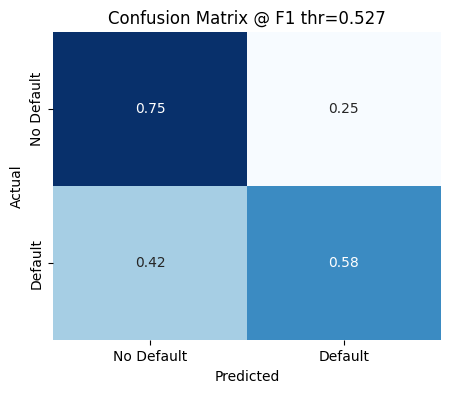

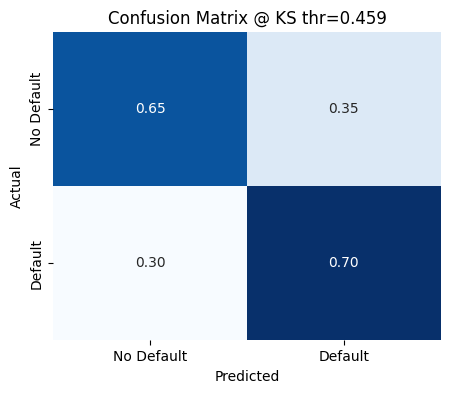

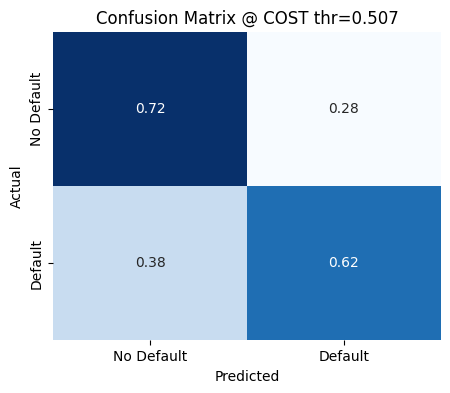

In [14]:
#Thresholds analysis for the full model
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_recall_curve, roc_curve, confusion_matrix,
    f1_score, average_precision_score
)
import matplotlib.pyplot as plt

# ---------- helpers ----------

def plot_cm_normalized(y_true, y_pred, labels=["No Default","Default"], title="Confusion Matrix (normalized)"):
    """
    Compute and plot normalized confusion matrix (row-wise).
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # <-- correct row-wise normalization

    # DataFrame for visualization
    cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)

    # Plot
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(title)
    plt.show()

def best_threshold_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    i = int(np.argmax(f1))
    return float(thr[i]) if i < len(thr) else 0.5, float(f1[i])

def best_threshold_ks(y_true, proba):
    fpr, tpr, thr = roc_curve(y_true, proba)
    ks_vals = tpr - fpr
    i = int(np.argmax(ks_vals))
    return float(thr[i]), float(ks_vals[i])

def best_threshold_cost(y_true, proba, cost_fn=5.0, cost_fp=2):
    """
    Minimize expected cost:
      C = cost_fn * FN + cost_fp * FP
    Adjust cost_fn and cost_fp according to the penalty of accepting bads vs. rejecting goods.
    """
    thr_grid = np.quantile(proba, np.linspace(0.01, 0.99, 99))
    best_C, best_t = None, 0.5
    for t in thr_grid:
        yhat = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
        C = cost_fn * fn + cost_fp * fp
        if (best_C is None) or (C < best_C):
            best_C, best_t = C, t
    return float(best_t), float(best_C)


# ---------- choose thresholds ----------
t_f1, f1_val = best_threshold_f1(y_test_all, p_full)
t_ks, ks_val = best_threshold_ks(y_test_all, p_full)
t_cost, cost_val = best_threshold_cost(y_test_all, p_full, cost_fn=5.0, cost_fp=1.0)  # adjust costs

print(f"Best F1 threshold = {t_f1:.4f}  (F1={f1_val:.4f})")
print(f"Best KS threshold = {t_ks:.4f}  (KS={ks_val:.4f})")
print(f"Best COST threshold = {t_cost:.4f}  (Cost={cost_val:.1f})")

# ---------- normalized confusion matrices ----------
plot_cm_normalized(y_test_all, (p_full >= t_f1).astype(int), title=f"Confusion Matrix @ F1 thr={t_f1:.3f}")
plot_cm_normalized(y_test_all, (p_full >= t_ks).astype(int), title=f"Confusion Matrix @ KS thr={t_ks:.3f}")
plot_cm_normalized(y_test_all, (p_full >= t_cost).astype(int), title=f"Confusion Matrix @ COST thr={t_cost:.3f}")


## Decile & Cumulative Gains Analysis

In credit scoring, it is not enough to only look at ROC-AUC or PR-AUC.  
We also want to understand **how well the model concentrates risk**.  

Two common tools for this are:

- **Default rate by decile:**  
  We sort customers by predicted probability of default and split them into 10 equal groups (deciles).  
  - **Decile 10 = highest risk.**  
  - If the model is effective, default rates should be much higher in the top deciles compared to the bottom ones.

- **Cumulative gains curve:**  
  This curve answers the business question:  
  *“If I reject the riskiest X% of customers, what % of defaults do I avoid?”*  
  - The diagonal orange line is a random baseline (no predictive power).  
  - The blue curve shows the model: the more it bows upward, the better the concentration of risk.

These two plots provide a business-oriented interpretation of model performance, complementing the ROC and PR metrics.


,decile,n,bad,rate,cum_pop,cum_pop_pct,cum_bad,cum_bad_pct
0,1,45170,15454,0.342130,45170,0.100001,15454,0.261928
1,2,45169,10751,0.238017,90339,0.200000,26205,0.444145
2,3,45170,8651,0.191521,135509,0.300001,34856,0.590770
3,4,45169,6821,0.151011,180678,0.400000,41677,0.706378
4,5,45169,5408,0.119728,225847,0.499999,47085,0.798037
5,6,45170,4345,0.096192,271017,0.600000,51430,0.871680
6,7,45169,3279,0.072594,316186,0.699999,54709,0.927255
7,8,45170,2261,0.050055,361356,0.800000,56970,0.965577
8,9,45169,1359,0.030087,406525,0.899999,58329,0.988610
9,10,45170,672,0.014877,451695,1.000000,59001,1.000000


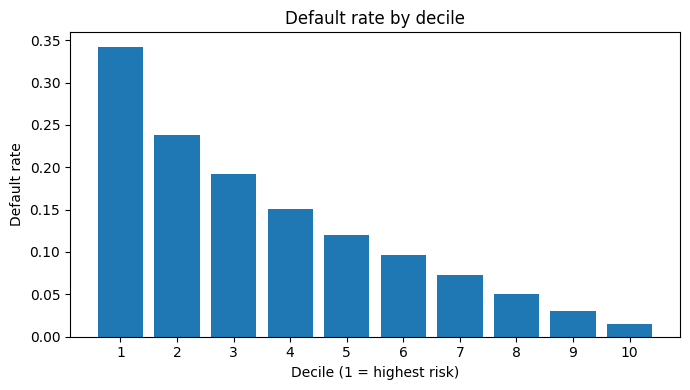

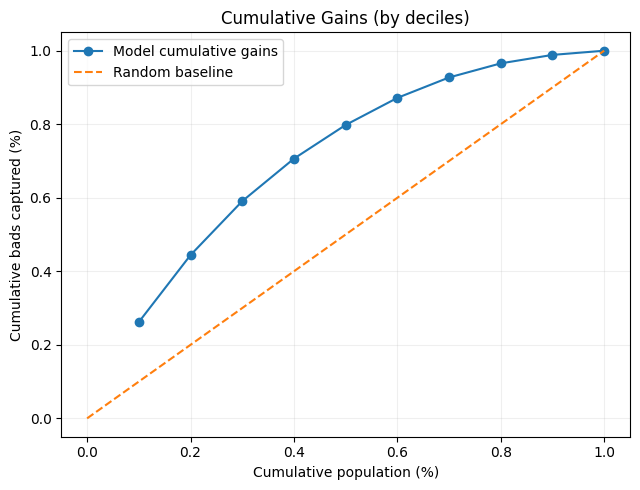

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== 0) Sanity check: make sure 'proba' is P(Default) ======
def ensure_positive_class_prob(y_true, proba):
    """
    If the mean of y in the top 10% of scores is LOWER than in the bottom 10%,
    then 'proba' is probably P(No-Default). In that case, invert it: 1 - proba.
    """
    dfc = pd.DataFrame({"y": y_true, "p": proba})
    n10 = max(100, int(0.10 * len(dfc)))  # minimum sample size for the check
    top_mean = dfc.sort_values("p", ascending=False).head(n10)["y"].mean()
    bot_mean = dfc.sort_values("p", ascending=True).head(n10)["y"].mean()
    return proba if top_mean >= bot_mean else (1.0 - proba)

# ====== 1) Decile table ======
def decile_table(y_true, proba, k=10):
    """
    Build a decile table for a scoring model.
    Convention: Decile 1 = highest risk, Decile k = lowest risk.
    Returns per-decile counts, bads, rate, and cumulative metrics.
    """
    df = pd.DataFrame({"y": np.asarray(y_true), "p": np.asarray(proba)})

    # qcut bins in ascending score (low->high). Get numeric bins 0..k-1
    bins = pd.qcut(df["p"], q=k, labels=False, duplicates="drop")

    # Remap so 1 = highest risk (invert the bin index)
    df["decile"] = (k - bins).astype(int)

    # Per-decile aggregates (1..k = high->low risk)
    dec = (df.groupby("decile", observed=True)
             .agg(n=("y","size"), bad=("y","sum"), rate=("y","mean"))
             .sort_index()
             .reset_index())

    # Cumulative from the highest-risk end
    dec["cum_pop"] = dec["n"].cumsum()
    dec["cum_pop_pct"] = dec["cum_pop"] / dec["n"].sum()

    total_bad = max(dec["bad"].sum(), 1)   # guard for division by zero
    dec["cum_bad"] = dec["bad"].cumsum()
    dec["cum_bad_pct"] = dec["cum_bad"] / total_bad

    return dec


dec = decile_table(y_test_all, p_full, k=10)
display(dec)

# ====== 3) Plot: Default rate by decile ======
plt.figure(figsize=(7,4))
plt.bar(dec["decile"].astype(str), dec["rate"])
plt.xlabel("Decile (1 = highest risk)")
plt.ylabel("Default rate")
plt.title("Default rate by decile")
plt.tight_layout()
plt.show()

# ====== 4) Plot: Cumulative Gains (bads vs population) ======
x = dec["cum_pop_pct"].values
y = dec["cum_bad_pct"].values

plt.figure(figsize=(6.5,5))
plt.plot(x, y, marker="o", label="Model cumulative gains")
plt.plot([0,1], [0,1], linestyle="--", label="Random baseline")
plt.xlabel("Cumulative population (%)")
plt.ylabel("Cumulative bads captured (%)")
plt.title("Cumulative Gains (by deciles)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


# Final Model Training

After exploring multiple models, tuning hyperparameters, calibrating probabilities, and validating performance through cross-validation and decile analysis, we now train the **final model** on the entire dataset.  

This step consolidates the best approach and produces a model that can be exported and used for scoring new loan applications.


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=["default_status"])
y = df["default_status"].astype(int)

# Detect categorical & numeric columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        # numeric columns go through ("passthrough")
    ],
    remainder="passthrough"
)

rf_final = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=25,
    max_features="sqrt",
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", rf_final),
])


pipe.fit(X, y)


#Save single artifact for production/Streamlit

joblib.dump(pipe, "final_scoring_model.joblib")
print("Saved: final_scoring_model.joblib")


Saved: final_scoring_model.joblib
